# Implementation of "A Neural Algorithm of Style"
This is an implementation in Python and [Caffe](http://caffe.berkeleyvision.org/) of a recent paper, *A Neural Algorithm of Artistic Style* by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge, that became very well-known and has some online implementations such as <https://deepart.io/>.  The paper is available at <http://arxiv.org/abs/1508.06576> and I refer to many of its equations in this Python notebook. This took inspiration and methods from some of the numerous implementations already available of this:

 - <https://github.com/jcjohnson/neural-style>
 - <https://github.com/kaishengtai/neuralart>
 - <https://github.com/andersbll/neural_artistic_style>
 - <https://github.com/fzliu/style-transfer>
 - <https://github.com/woodrush/neural-art-tf>

## Setup
Standard imports are below. `cv2` is needed only for image resizing and saving.

`caffe` is via <http://caffe.berkeleyvision.org/> and this, as far as I know, has bindings only for Python 2.x.

In [32]:
import caffe, numpy, cv2, scipy.optimize

The below is only for the sake of displaying images in this notebook. If running this code standalone, it can be omitted.

In [2]:
import IPython.display

Now, initialize caffe to make use of GPU 0.
(If you have no GPU, or no CUDA support in Caffe, replace the below with `caffe.set_mode_cpu()` and expect things to take much longer.)

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

## Loading Pre-trained Neural Network
We require a pre-trained neural network for this. Many will work here, but here I am using the Caffenet model from <http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel> and the network description from <https://github.com/fzliu/style-transfer/blob/master/models/caffenet/deploy.prototxt>. It is a small enough model that it fits on some more modest GPUs. The below loads this model into Caffe:

In [4]:
net = caffe.Net("caffenet/deploy.prototxt",
                "caffenet/bvlc_reference_caffenet.caffemodel",
                caffe.TEST)

Check stdout/stderr if this call has problems. Errant `caffe` calls might also crash the whole Python instance.

See <https://github.com/fzliu/style-transfer/tree/master/models> for some models that are already in the correct format. Another interesting one, already in Caffe's format, is at <http://illustration2vec.net/>.

We can inspect the neural network's structure too. <http://caffe.berkeleyvision.org/tutorial/net_layer_blob.html> contains a good explanation of what Net, Layer, and Blob mean, to give this some context.  <http://caffe.berkeleyvision.org/tutorial/layers.html> explains the different layer types shown below (and others). However, understanding this is not crucial to what else we do.

In [5]:
for i,layer in enumerate(net.layers):
    print("%d: %s, %d blobs" % (i, layer.type, len(layer.blobs)))
    for j,blob in enumerate(layer.blobs):
        print("\tBlob %d: %d x %d channels of %dx%d" %
              (j, blob.num, blob.channels, blob.width, blob.height))

0: Input, 0 blobs
1: Convolution, 2 blobs
	Blob 0: 96 x 3 channels of 11x11
	Blob 1: 96 x 1 channels of 1x1
2: ReLU, 0 blobs
3: Pooling, 0 blobs
4: LRN, 0 blobs
5: Convolution, 2 blobs
	Blob 0: 256 x 48 channels of 5x5
	Blob 1: 256 x 1 channels of 1x1
6: ReLU, 0 blobs
7: Pooling, 0 blobs
8: LRN, 0 blobs
9: Convolution, 2 blobs
	Blob 0: 384 x 256 channels of 3x3
	Blob 1: 384 x 1 channels of 1x1
10: ReLU, 0 blobs
11: Convolution, 2 blobs
	Blob 0: 384 x 192 channels of 3x3
	Blob 1: 384 x 1 channels of 1x1
12: ReLU, 0 blobs
13: Convolution, 2 blobs
	Blob 0: 256 x 192 channels of 3x3
	Blob 1: 256 x 1 channels of 1x1
14: ReLU, 0 blobs
15: Pooling, 0 blobs


The Blobs are the actual part we're interested in, particularly, those corresponding to convolution layers, and we can inspect some of them below:

In [6]:
for name in net.blobs.keys():
    blob = net.blobs[name]
    print("Blob '%s': %d x %d channels of %dx%d" %
          (name, blob.num, blob.channels, blob.width, blob.height))

Blob 'data': 10 x 3 channels of 227x227
Blob 'conv1': 10 x 96 channels of 55x55
Blob 'pool1': 10 x 96 channels of 27x27
Blob 'norm1': 10 x 96 channels of 27x27
Blob 'conv2': 10 x 256 channels of 27x27
Blob 'pool2': 10 x 256 channels of 13x13
Blob 'norm2': 10 x 256 channels of 13x13
Blob 'conv3': 10 x 384 channels of 13x13
Blob 'conv4': 10 x 384 channels of 13x13
Blob 'conv5': 10 x 256 channels of 13x13
Blob 'pool5': 10 x 256 channels of 6x6


We need to pick certain layers that represent "content", and certain layers that represent "style".  The paper gives some more information on this, but these layers are also specific to the model and involve some level of trial-and-error. Lower layers capture more detailed pixel information, while higher layers capture a higher-level representation.

In [7]:
style_layers = ["conv1", "conv2", "conv3", "conv4", "conv5"]
content_layers = ["conv4"]
layers = [l for l in net.blobs if l in content_layers or l in style_layers]

## Input Images
Next, we need a content image and a style image - an image which contributes content we're trying to match, and an image which contributes style we're trying to match.  (Actually, there can be multiple content images and multiple style images, but that's another matter.)

Let's try this commonly-known artwork as a style image:

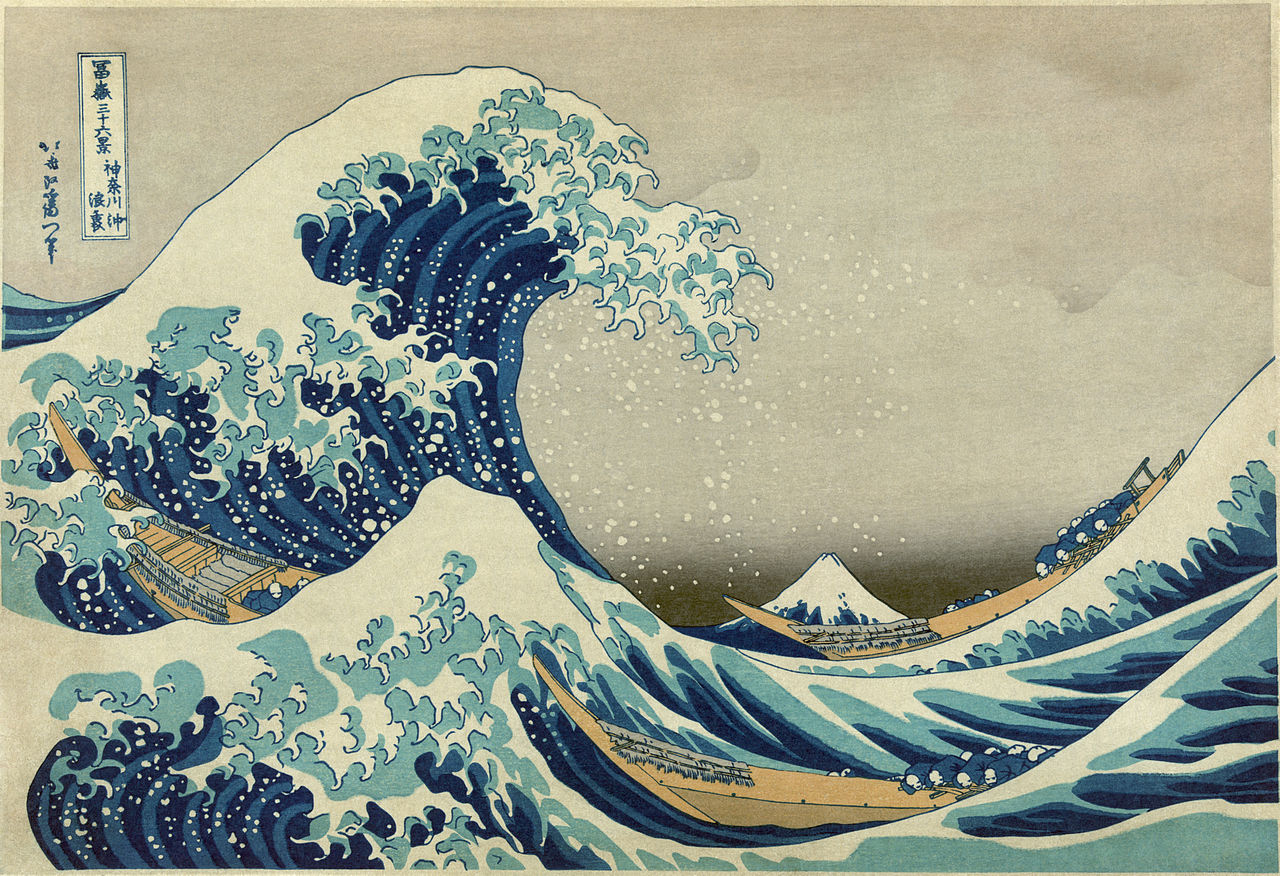

In [8]:
style_image_filename = "./1280px-Great_Wave_off_Kanagawa2.jpg"
IPython.display.Image(filename = style_image_filename)

and this photograph as a content image:

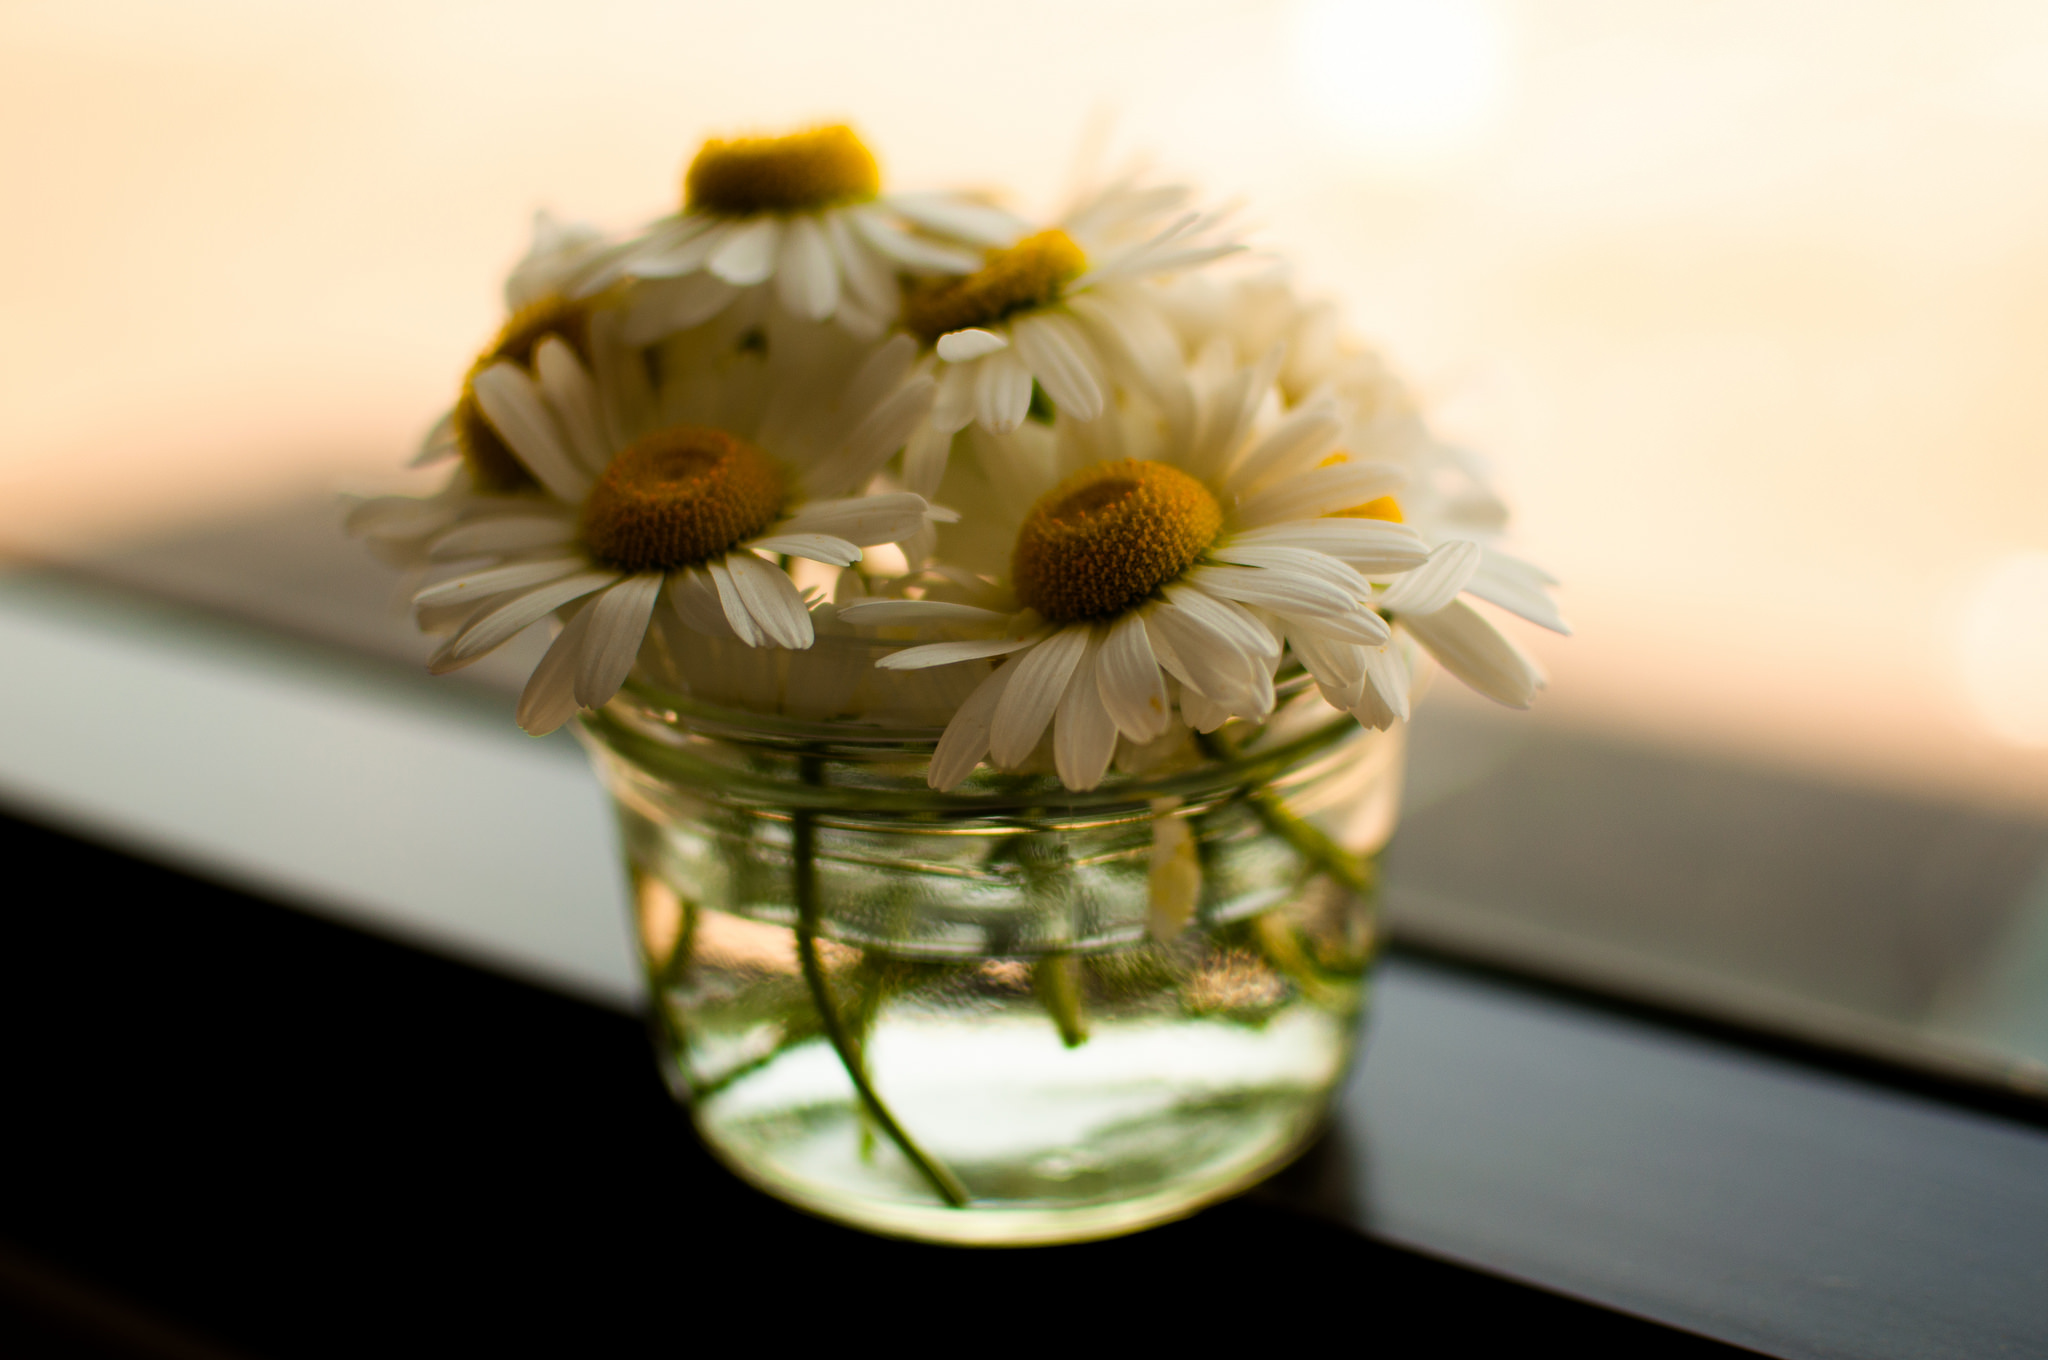

In [9]:
content_image_filename = "./13681848113_c41cd968d4_k.jpg"
IPython.display.Image(filename = content_image_filename)

And actually load these images:

In [10]:
style   = caffe.io.load_image(style_image_filename)
content = caffe.io.load_image(content_image_filename)

## Preprocessing
We need to condition our input images to be in the same format and range as the images on which the neural network was trained. Luckily, most of these networks were trained on [ImageNet](http://www.image-net.org/) data and this information is available via <https://github.com/BVLC/caffe/blob/master/python/caffe/imagenet/ilsvrc_2012_mean.npy>. We can load this and produce a caffe.io.Transformer from it, and we must use this throughout anytime we have image data coming in or out of the neural network.

In [11]:
mean_data = numpy.load("caffenet/ilsvrc_2012_mean.npy")
xform = caffe.io.Transformer({"data": net.blobs["data"].data.shape})
xform.set_mean("data", mean_data.mean(1).mean(1))
xform.set_channel_swap("data", (2,1,0))
xform.set_transpose("data", (2,0,1))
xform.set_raw_scale("data", 255)

We also need to scale the images to a certain size, and in some cases scale the style image up a little.  The below does this, using the familiar `cv2.resize` to scale each image's longest edge to `size` (but basically any image resizing routine will work).

In [12]:
size = 512
style_scale = 1.2

f = float(size) / max(content.shape[:2])
content_scaled = cv2.resize(content, (0, 0), fx=f, fy=f)
f = style_scale * float(size) / max(style.shape[:2])
style_scaled = cv2.resize(style, (0, 0), fx=f, fy=f)

`size` can be made much larger for higher-resolution results, just be aware that it will raise computation time sharply.

## Feature Responses in Neural Network
Finally, at this point we can get into the actual method of the paper (around page 9 now). Below we are computing the *feature responses* of the content image on the layers of the neural network that we selected as content layers. The first part is adapting the neural network's shape to this particular image size, and then running a forward pass of the neural network using this (conditioned) input.

We make this part a function, since it comes up in many other places:

In [13]:
def net_forward(img):
    ch, w, h = img.shape[2], img.shape[0], img.shape[1]
    net.blobs["data"].reshape(1, ch, w, h)
    xform.inputs["data"] = (1, ch, w, h)
    
    net.blobs["data"].data[0] = xform.preprocess("data", img)
    net.forward()

After the `net_forward` call, we need to collect the data from the layers we're concerned with. For the content representation, this is just the activations at those layers, flattened out a bit. We reuse this later, so it also is made a function:

In [14]:
def get_content_repr(img):
    resp = {}
    for layer in layers:
        act = net.blobs[layer].data[0].copy()
        act.shape = (act.shape[0], -1)
        resp[layer] = act
    return(resp)

We do nearly the same thing to compute the style representation on the style image. Where it differs from the content image is that here we're building a feature correlation, for which we use the Gram matrix (see page 10 of the paper).  `numpy.dot(act, act.T)` is one easy way to compute this; `sgemm` from [BLAS](http://www.math.utah.edu/software/lapack/lapack-blas/sgemm.html) is another.

In [15]:
def get_style_repr(img):
    resp = {}
    for layer in style_layers:
        act = net.blobs[layer].data[0].copy()
        act.shape = (act.shape[0], -1)
        resp[layer] = numpy.dot(act, act.T)
    return(resp)

net_forward(style_scaled)
style_repr = get_style_repr(style_scaled)

net_forward(content_scaled)
content_repr = get_content_repr(content_scaled)

`content_repr` and `style_repr` then are dictionaries whose keys are the layer name, and whose values are the image representation at that layer (of the content features of our content image, and style features of our style image, respectively.)

Now, all we need to do is find an image that, when run through this same neural network, produces approximately the same content representation and the same style representation as what we just computed, and looks okay - for whatever vague definition of "approximately" and "looks okay" we choose to apply. That's simple enough, right? It's just a minimization problem with roughly this many dimensions:

In [16]:
content_scaled.size

522240

## Generating a New Image

In [17]:
# TODO: Explain this better.
numpy.random.seed(12345)
img_init = xform.preprocess(
    "data", numpy.random.randn(*(net.blobs["data"].data.shape[1:])))

data_min = -xform.mean["data"][:,0,0]
data_max = data_min + xform.raw_scale["data"]
data_bounds = [(data_min[0], data_max[0])]*(img_init.size/3) + \
              [(data_min[1], data_max[1])]*(img_init.size/3) + \
              [(data_min[2], data_max[2])]*(img_init.size/3)

The method of this that the paper suggests (around page 11) is to start from a white noise image, and use gradient-descent on that image to jointly minimize the difference between its content representation and style representation, and the content and style representation we computed above.

Most implementations followed something like this. A change that some of them adopted was to start from a pink noise image or from the content image, rather than a white noise image.

### Loss function

We can do this with standard optimization routines, provided that we define some sort of overall loss function and we have its gradient with respect to that generated image. Happily, since we are using neural networks that allow backpropagation, we have most of the tools needed for this.

The paper defines different loss function for content and for style. These equations are copied more or less verbatim in the loss function that is below, leaving the explanation to the paper and noting the relevant equations in comments.

The values `alpha` and `beta` are the $\alpha$ and $\beta$ noted in equation 7 in the paper, giving the weighting factors for content and style loss, respectively.  `tv_weight` is the weighting for another loss function that was not defined in the paper, but was used in various implementations (possibly first in [kaishengtai/neuralart](https://github.com/kaishengtai/neuralart), called *total variation gradient*, which contributes to smoothness in the final result.

In [18]:
ratio = 1e3
alpha = 1
beta = 1e4
tv_strength = 1e-3

def loss_function(x):
    # Reshape the (flattened) input and feed it into the network:
    net_in = x.reshape(net.blobs["data"].data.shape[1:])
    net.blobs["data"].data[0] = net_in
    net.forward()

    # Get content & style representation of net_in:
    content_repr_tmp = get_content_repr(net_in)
    style_repr_tmp = get_style_repr(net_in)
    
    # Starting at last layer (see self.layers), propagate error back.
    loss = 0
    net.blobs[layers[-1]].diff[:] = 0
    for i, layer in enumerate(reversed(layers)):
        next_layer = None if i == len(layers)-1 else layers[-i-2]
        grad = net.blobs[layer].diff[0]

        # Matching paper notation for equations 1 to 7:
        Pl = content_repr[layer]
        Fl = content_repr_tmp[layer]
        Nl = content_repr_tmp[layer].shape[0]
        Ml = content_repr_tmp[layer].shape[1]
        Gl = style_repr_tmp[layer]
        Al = style_repr[layer]
        
        # Content loss:
        w = 1.0 / len(content_layers)
        if layer in content_layers:
            d = Fl - Pl
            # Equations 1 & 2:
            loss += w * (d**2).sum() / 2
            grad += w * (d * (Fl > 0)).reshape(grad.shape)

        # Style loss:
        w = 1.0 / len(style_layers)
        if layer in style_layers:
            q = (Nl * Ml)**-2
            d = Gl - Al
            # Equation 4:
            El = q/4 * (d**2).sum()
            # Equation 6:
            dEl = q * numpy.dot(d, Fl) * (Fl > 0)
            # Equation 5:
            loss += w * El * ratio
            # Equation 7 (ish):
            grad += w * dEl.reshape(grad.shape) * ratio

        # Finally, propagate this error back into the network
        net.backward(start=layer, end=next_layer)
        if next_layer is None:
            grad = net.blobs["data"].diff[0]
        else:
            grad = net.blobs[next_layer].diff[0]

    # Total Variation Gradient:
    tv_strength = 1e-2
    x_diff = net_in[:, :-1, :-1] - net_in[:, :-1, 1:]
    y_diff = net_in[:, :-1, :-1] - net_in[:, 1:, :-1]
    tv = numpy.zeros(grad.shape)
    tv[:, :-1, :-1] += x_diff + y_diff
    tv[:, :-1, 1:]  -= x_diff
    tv[:, 1:,  :-1] -= y_diff
    grad += tv_strength * tv
            
    # Flatten gradient (as minimize() wants to handle it):
    grad = grad.flatten().astype(numpy.float64)

    return loss, grad

### Minimization

With this (large, kind of complicated-looking) loss function designed, what remains is to pass this function to some standard optimization routine. SciPy has [several](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html); we'll use [L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb), as many implementations do (some also use Adam). Note that:

 - As we're supplying a gradient to help the optimization, we've set `jac` to `True`.
 - We can (and generally should) tune the number of iterations.
 - The starting value is our target image `img_init` (flattening only to put it in the desired format).  We could, if we wanted to, perform optimization in multiple calls, and simply pass in intermediate results instead of `img_init`.
 - We tell it with `disp` to output detailed information - however, none of this is visible here in the Python notebook (it goes to stdout). We could also set a callback if we wanted to be notified per-iteration - for instance, to visualize the results as they are refined.

This is the central "do-everything" call, and it will take its time to run...

In [19]:
res = scipy.optimize.minimize(loss_function,
                              img_init.flatten(),
                              args = (),
                              options = {"maxiter": 1000, "maxcor": 8, "disp": True},
                              method = "L-BFGS-B",
                              jac = True,
                              bounds = data_bounds)

### Collecting results
Whenever that call happens to finish, we just need to collect its results. We can do this via field `x` in `res`, the [OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html) that `scipy.optimize.minimize` returns, or we can get it directly from the neural network's inputs (in which case the data already is in the correct shape).

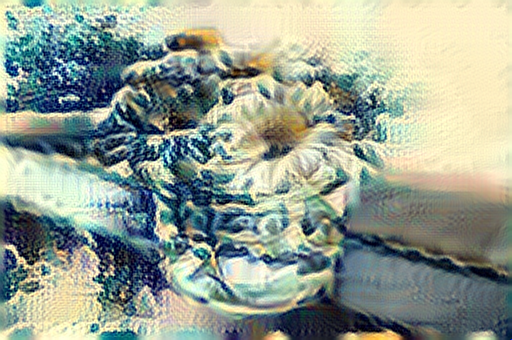

In [30]:
output_filename = "out_water2.png"
data = res.x.reshape(net.blobs["data"].data.shape)
# Also acceptable:
# data = net.blobs["data"].data
image = (255 * xform.deprocess("data", data)).astype(numpy.uint8)
cv2.imwrite(output_filename, image[:,:,::-1]);
IPython.display.Image(filename = output_filename)